## SSAC - Exploration 15 - Transformer, Attention : Chatbot

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1. 데이터 수집하기

---

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv)

In [8]:
path_to_dataset = os.getenv('HOME')+'/aiffel/songys_chatbot/ChatbotData.csv'
path_to_dataset

'/home/ssac7/aiffel/songys_chatbot/ChatbotData.csv'

In [9]:
i = 0
with open(path_to_dataset, errors='ignore') as file:
    lines = file.readlines()
for line in lines:
    print(line)
    i += 1
    if i > 5:
        break


Q,A,label

12시 땡!,하루가 또 가네요.,0

1지망 학교 떨어졌어,위로해 드립니다.,0

3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0

3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0

PPL 심하네,눈살이 찌푸려지죠.,0



In [10]:
chat_data = pd.read_csv(path_to_dataset)
chat_data.head(2)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0


In [11]:
chat_data.sample(5)

,Q,A,label
1028,놀아줘,지금 그러고 있어요.,0
9891,사랑은 영원해?,사랑은 한 순간이면서 영원한거 같아요.,2
1074,눈썹이 씰룩씰룩,저도 보고 싶어요.,0
6729,술먹고 연락도 없는,걱정되시겠어요.,1
6559,빌어먹을.,제길.,1


In [12]:
chat_data.duplicated().sum()

0

### Step 2. 데이터 전처리하기

---

In [13]:
question = chat_data['Q']
answer = chat_data['A']
print(type(question), type(answer))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [14]:
def preprocess_sentence(sentence):
    sentence = sentence.strip() # 문장 양 끝 공백 없애기

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 단어와 ?.!, 사이 한칸 띄기
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백이 여러칸이면 한칸으로

    # 혈액형 얘기가 있어서 알파벳 유지, 자음, 모음으로 이루어진 표현이 있길래 유지. 
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip() # 문장 양 끝 공백 없애기
    return sentence

In [15]:
chat_data['prc_q'] = chat_data['Q'].map(lambda x : preprocess_sentence(x))
chat_data['prc_a'] = chat_data['A'].map(lambda x : preprocess_sentence(x))

In [16]:
chat_data.sample(10)

,Q,A,label,prc_q,prc_a
3477,요즘 사람이 무서워,인생을 알아가고 있군요.,0,요즘 사람이 무서워,인생을 알아가고 있군요 .
5935,너무 잡고 싶지만 도저히 잡지 못해,서로를 위한 선택이길 바랄게요.,1,너무 잡고 싶지만 도저히 잡지 못해,서로를 위한 선택이길 바랄게요 .
10342,썸녀랑 거의 사귀는 수준인데 꼭 고백해야해?,고백을 안하고 사귀는 경우도 있지만 정확하게 관계를 정의 짓는게 좋아요.,2,썸녀랑 거의 사귀는 수준인데 꼭 고백해야해 ?,고백을 안하고 사귀는 경우도 있지만 정확하게 관계를 정의 짓는게 좋아요 .
3866,입덕했어,즐기실 일만 남았네요.,0,입덕했어,즐기실 일만 남았네요 .
11099,좋아하는 사람 프사랑 비슷한 거 걸어?,커플 프사 느낌으로 하면 좋죠.,2,좋아하는 사람 프사랑 비슷한 거 걸어 ?,커플 프사 느낌으로 하면 좋죠 .
6958,어제 그녀를 또 보았어.,많이 놀랐겠어요.,1,어제 그녀를 또 보았어 .,많이 놀랐겠어요 .
6830,아련하게 조금씩 잊게 되나보네,그렇게 잊어가는 건가봐요.,1,아련하게 조금씩 잊게 되나보네,그렇게 잊어가는 건가봐요 .
681,난 쓰레기야,그런 생각은 버리세요.,0,난 쓰레기야,그런 생각은 버리세요 .
9246,남사친이 나를 좋아하는 것 같은데 어떡함,이성으로 한 번 생각해보세요.,2,남사친이 나를 좋아하는 것 같은데 어떡함,이성으로 한 번 생각해보세요 .
9503,내가 좋아하는 거 티내면 싫어할까?,부담스러울 수도 있겠어요.,2,내가 좋아하는 거 티내면 싫어할까 ?,부담스러울 수도 있겠어요 .


+ 온점이 있는 문장과 없는 문장이 있어서 이건 어떻게 처리해야 할지 고민된다. 
+ 띄어쓰기를 문장마다 다르게 해서 문제가 될 수 있을 것 같다.

### Step 3. SubwordTextEncoder 사용하기

---

내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용.

3-1. 문장 길이 분포 살펴보기

In [17]:
chat_data['count_q'] = chat_data['prc_q'].map(lambda x : len(x.split()))
chat_data['count_a'] = chat_data['prc_a'].map(lambda x : len(x.split()))

In [18]:
chat_data['count_q'].max()

16

In [19]:
chat_data['count_a'].max()

24

<AxesSubplot:>

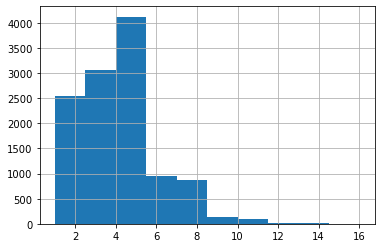

In [20]:
chat_data['count_q'].hist()

<AxesSubplot:>

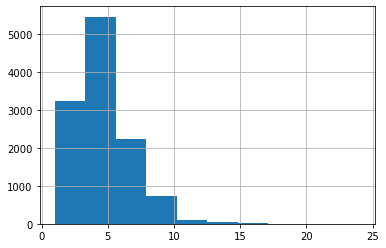

In [21]:
chat_data['count_a'].hist()

In [22]:
len(chat_data)

11823

In [23]:
cond = chat_data['count_a'] > 11
len(chat_data[cond]) / len(chat_data) * 100

0.7781442950181848

In [24]:
chat_data[cond].sample(3)

,Q,A,label,prc_q,prc_a,count_q,count_a
4104,절대불공평,서로 다르게 태어난 이유는 저마다의 목소리를 내기 위해서예요. 자신의 목소리를 들어...,0,절대불공평,서로 다르게 태어난 이유는 저마다의 목소리를 내기 위해서예요 . 자신의 목소리를 들...,1,13
9110,꿈에서 자꾸 어떤 여자애가 나와,자기도 모르는 사이에 관심이 생긴 건 아닐까요? 차분히 생각해 보세요.,2,꿈에서 자꾸 어떤 여자애가 나와,자기도 모르는 사이에 관심이 생긴 건 아닐까요 ? 차분히 생각해 보세요 .,5,12
11135,좋아하는 사람이 연애에 관심이 없는 거 같애,사랑에 관심 없는 사람도 많아요. 눈치가 없을 수도 있으니 적극적으로 다가가보세요.,2,좋아하는 사람이 연애에 관심이 없는 거 같애,사랑에 관심 없는 사람도 많아요 . 눈치가 없을 수도 있으니 적극적으로 다가가보세요 .,7,13


In [25]:
cond = chat_data['count_q'] > 11
len(chat_data[cond]) / len(chat_data) * 100

0.20299416391778738

In [26]:
chat_data[cond].sample(3)

,Q,A,label,prc_q,prc_a,count_q,count_a
11248,좋아하는 오빠가 최근에 연락이 계속 늦거나 이어지지 않는데 그냥 연락 끊어야 할까.,그러는 것이 맘 편할지도 몰라요.,2,좋아하는 오빠가 최근에 연락이 계속 늦거나 이어지지 않는데 그냥 연락 끊어야 할까 .,그러는 것이 맘 편할지도 몰라요 .,13,6
10888,이 사람 만나면서 내 자존감이 떨어지는 것 같아 안 만나는게 답이야?,그 누구와도 비교하지 마세요.,2,이 사람 만나면서 내 자존감이 떨어지는 것 같아 안 만나는게 답이야 ?,그 누구와도 비교하지 마세요 .,12,5
11462,짝남한테 주말에 만나자고 했는데 일 있대 계속 언제 되는지 물어봐도 되나.,거절 하는게 느껴지면 그만하는게 좋겠어요.,2,짝남한테 주말에 만나자고 했는데 일 있대 계속 언제 되는지 물어봐도 되나 .,거절 하는게 느껴지면 그만하는게 좋겠어요 .,12,6


+ 전체 데이터 수가 11823개로 많은 편이 아니라 긴 문장을 제거해야 할지 판단하기 위해 조건을 바꿔가며 데이터를 살펴보았다.
+ 띄어쓰기가 잘 안되어 있어서 띄어쓰기로 구분한 문장 길이로는 깔끔한 판단이 어렵지만 대답, 질문이 11 이상이 되면 전체 데이터에서 차지하는 비중도 적고 다른 질문들에 비해 부연 설명이 많은 것 같다.

In [29]:
questions = chat_data['prc_q']
answers = chat_data['prc_a']

In [30]:
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [31]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [32]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


In [33]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8363


3-2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

---

`tokenizer.encode()`로 각 단어를 정수로 변환하고 또는 `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환한다.

In [34]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5827, 605, 2499, 4173]
정수 인코딩 후의 21번째 답변 샘플: [2683, 7666, 8, 6375, 95, 1]


In [35]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 13
print(MAX_LENGTH)

13


In [36]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 13 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 13으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [37]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11144
필터링 후의 답변 샘플 개수: 11144


3-3. 교사 강요(Teacher Forcing) 사용하기
+ 이번기 예측값이 아닌 정답을 다음기 입력으로 사용하기
---

In [38]:
BATCH_SIZE = 64
BUFFER_SIZE = len(questions)

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 정답에서 end token 빼고 다음기 인풋으로 쓰기
    },
    {
        'outputs': answers[:, 1:] # 정답에서 start token 빼고 라벨로
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


### Step 4. 모델 구성하기

---

트랜스포머 모델을 구현합니다.

In [39]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


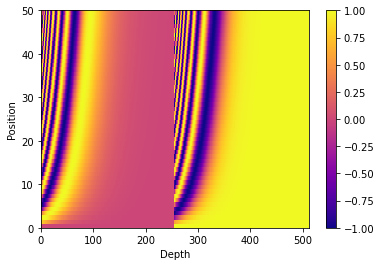

In [40]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='plasma')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [41]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output
print("슝=3")

슝=3


In [42]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [43]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [45]:
# 자신 다음에 나올 단어를 참고하지 않도록 마스킹
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [66]:
# 0 이 포함되어 있을 때 작동 확인
print(create_look_ahead_mask(tf.constant([[0, 2, 0, 3, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 0. 1.]
   [1. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [48]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [49]:
# 인코딩 층 쌓아 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [50]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [51]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

	# 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
	# 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

	# 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

	# Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### Step 5. 모델 평가하기

---

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.



In [52]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 1. 모델 생성

---

`num_layers`, `d-Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼파라미터값입니다.

논문에서 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

In [53]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2. 손실 함수(Loss function)

---

레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [54]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### 3. 커스텀된 학습률(Learning rate)

---

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 
널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

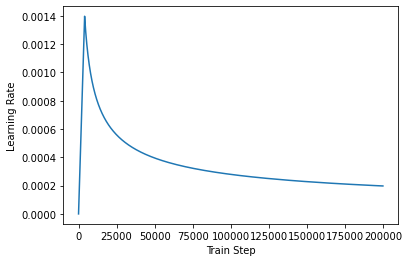

In [56]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4. 모델 컴파일

---

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [57]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


### 5. 훈련하기

---

총 20 에포크를 학습합니다.

In [58]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
175/175 [==============================] - 34s 196ms/step - loss: 4.5417 - accuracy: 0.0952
Epoch 2/20
175/175 [==============================] - 34s 192ms/step - loss: 3.6883 - accuracy: 0.1609
Epoch 3/20
175/175 [==============================] - 34s 194ms/step - loss: 3.1015 - accuracy: 0.1634
Epoch 4/20
175/175 [==============================] - 34s 196ms/step - loss: 2.8533 - accuracy: 0.1733
Epoch 5/20
175/175 [==============================] - 34s 194ms/step - loss: 2.6799 - accuracy: 0.1833
Epoch 6/20
175/175 [==============================] - 35s 197ms/step - loss: 2.5044 - accuracy: 0.1953
Epoch 7/20
175/175 [==============================] - 34s 196ms/step - loss: 2.3148 - accuracy: 0.2119
Epoch 8/20
175/175 [==============================] - 33s 190ms/step - loss: 2.1008 - accuracy: 0.2342
Epoch 9/20
175/175 [==============================] - 36s 204ms/step - loss: 1.8706 - accuracy: 0.2606
Epoch 10/20
175/175 [==============================] - 37s 213ms/step - l

In [59]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [60]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


임의의 문장으로부터 챗봇의 대답을 얻어봅시다.

In [61]:
sentence_generation('잘 지냈어?')

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .


'안부를 물어주시다니 감사합니다 .'

In [62]:
sentence_generation("배고프다.")

입력 : 배고프다.
출력 : 저도 밥 먹고 싶어요


'저도 밥 먹고 싶어요'

In [65]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'